## 1. Problem Statement

## Imports

In [1]:
import pandas as pd # for data manipulation,data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # for numerical calculation
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for interactive plotting with colors /used for plot interactive graph. I like it most for plot
from sklearn.preprocessing import LabelEncoder # Encode target labels with value between 0 and n_classes-1
from scipy import stats # offers variety of statistic functions
from sklearn.preprocessing import StandardScaler # removes the mean and scales each feature/variable to unit variance.

%matplotlib inline
plt.rcParams.update({'font.size': 30})

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier
import optuna 

import warnings
warnings.filterwarnings("ignore")


## Data

In [2]:
df = pd.read_csv("/kaggle/input/nigerian-gradaute-report-2018/Nigerian Graduates Destination Survey (2013 -2017) (Responses) - nigerian graduates survey 2018.csv")

In [3]:
df.head()

,Timestamp,What is your gender,Year of graduation,Title of course studied,Polytechnic/University attended,What is your highest level of education?,What best describes your current status?,How many jobs have you had since graduation including your current one?,Have you completed your NYSC?,"If you answered yes/ongoing to the previous question, what year did you (or will you) complete your NYSC?",...,What currency are you currently paid in?,Approximately how many hours a day do you currently work?,"As far as you are aware, what was most important to your current employer about your qualification?",How do you find out about your job(s)?,"Thinking about your current employment, did you work for your employer before or during your higher education study?",Which form of transport do you use the most?,Were you able to rent an apartment or buy a car from the salary you got from your first job?,My course of study prepared me well for employment,My course of study prepared me well for further studies,Which of these skills/knowledge did your higher education prepare you for?
0,2/8/2018 9:05:23,Male,2013,Electrical & Electronic Engineering,"Obafemi Awolowo University,Ile-Ife",Bachelor's degree,Working full time (paid employment),3,NaN,NaN,...,Naira,8.0,No one thing was important,Internship,No,Bus,Yes: From my first job,No,No,"Critical thinking skills, Ability to solve com..."
1,2/15/2018 12:11:32,Male,2014,Psychology,"Obafemi Awolowo University,Ile-Ife",Bachelor's degree,Working full time (paid employment),2,Yes,2017.0,...,Naira,8.0,IT/SIWES/Internship experience (gained as part...,Internship,No,BRT,No: From my current job,Strongly Disagree,Agree,"Critical thinking skills, Ability to solve com..."
2,2/15/2018 13:47:10,Female,2013,Economics,"Bells University of Technology, Otta",Bachelor's degree,Working full time (paid employment),2,Yes,NaN,...,Naira,14.0,The subject(s) I studied,Employer's website,No,Uber/Taxify/Taxi services,No: From my current job,Disagree,Agree,"Ability to work with others, Written communica..."
3,2/16/2018 13:01:34,Male,2017,Mass Communication (Communication and Language...,"Bowen University, Iwo",Master's degree,Self-employed/freelance/entrepreneur,0,Yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2/16/2018 13:18:03,Female,2013,Statistics,Ekiti State University,Bachelor's degree,Working full time (paid employment),3,Yes,2016.0,...,Naira,8.0,IT/SIWES/Internship experience (gained as part...,"Personal contacts, including family and friends",No,Commercial Vehicles,No,Agree,Agree,Critical thinking skills


## 2.Data Understanding


In [4]:
#previewing the information about the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5219 entries, 0 to 5218
Data columns (total 36 columns):
 #   Column                                                                                                                        Non-Null Count  Dtype  
---  ------                                                                                                                        --------------  -----  
 0   Timestamp                                                                                                                     5219 non-null   object 
 1   What is your gender                                                                                                           5219 non-null   object 
 2   Year of graduation                                                                                                            5219 non-null   int64  
 3   Title of course studied                                                                                          

In [5]:
#previewing the dimensions or shape (rows and columns)of the data

df.shape

(5219, 36)

In [6]:
#checking for missing values in our data

df.isna().sum()

Timestamp                                                                                                                          0
What is your gender                                                                                                                0
Year of graduation                                                                                                                 0
Title of course studied                                                                                                            0
Polytechnic/University attended                                                                                                    0
What is your highest level of education?                                                                                           0
What best describes your current status?                                                                                           0
How many jobs have you had since graduation including your current on

In [7]:
#checking unique values

df.nunique()

Timestamp                                                                                                                       5205
What is your gender                                                                                                                3
Year of graduation                                                                                                                 5
Title of course studied                                                                                                          127
Polytechnic/University attended                                                                                                  158
What is your highest level of education?                                                                                           6
What best describes your current status?                                                                                          10
How many jobs have you had since graduation including your current on

## 3.Exploratory Data Analysis --Data Wrangling\Cleaning

In [8]:
# we need to remove the these column since ther are irellevant

irellevant_cols = [
    "Timestamp",
    "If you answered yes/ongoing to the previous question, what year did you (or will you) complete your NYSC?",
    "Reason why?",
]

In [9]:
df.drop(irellevant_cols,axis=1, inplace =True)

In [10]:
# These columns have a lot of null values, about 68% of entries are null, so we need to remove them.

cols_to_remove = [
    "Thinking about your first employment after graduation, what was your job level?",
    "What is/was your job role?",
    "What sector/industry is your company in? (E.g. Banking, Agriculture, Telecommunication)",
    "Still thinking about your first employment, what is/was your monthly income level?",
    "Did you need your higher education qualification to get your first job (the actual qualification, not the subject of study)?",
    "What was the most significant reason for deciding to take your first job?",
]

In [11]:
df.drop(cols_to_remove, axis=1, inplace =True)

#### Encoding categorical values to numerical values

In [12]:
#Instantiation
le=LabelEncoder()

In [13]:
# use LabelEncoder to encode categorical variables
for col in df.columns:
    if df[col].dtype == 'object':
        not_null = df[col].notnull()
        df.loc[not_null, col] = le.fit_transform(df.loc[not_null, col])

####  Fill  null values with mean

In [14]:
for col in df.columns:
    if df[col].isna().sum() > 0:
            df[col].replace(np.NaN, df[col].mean(), inplace = True)

## 4. Preprocessing

#### correlation

<Axes: >

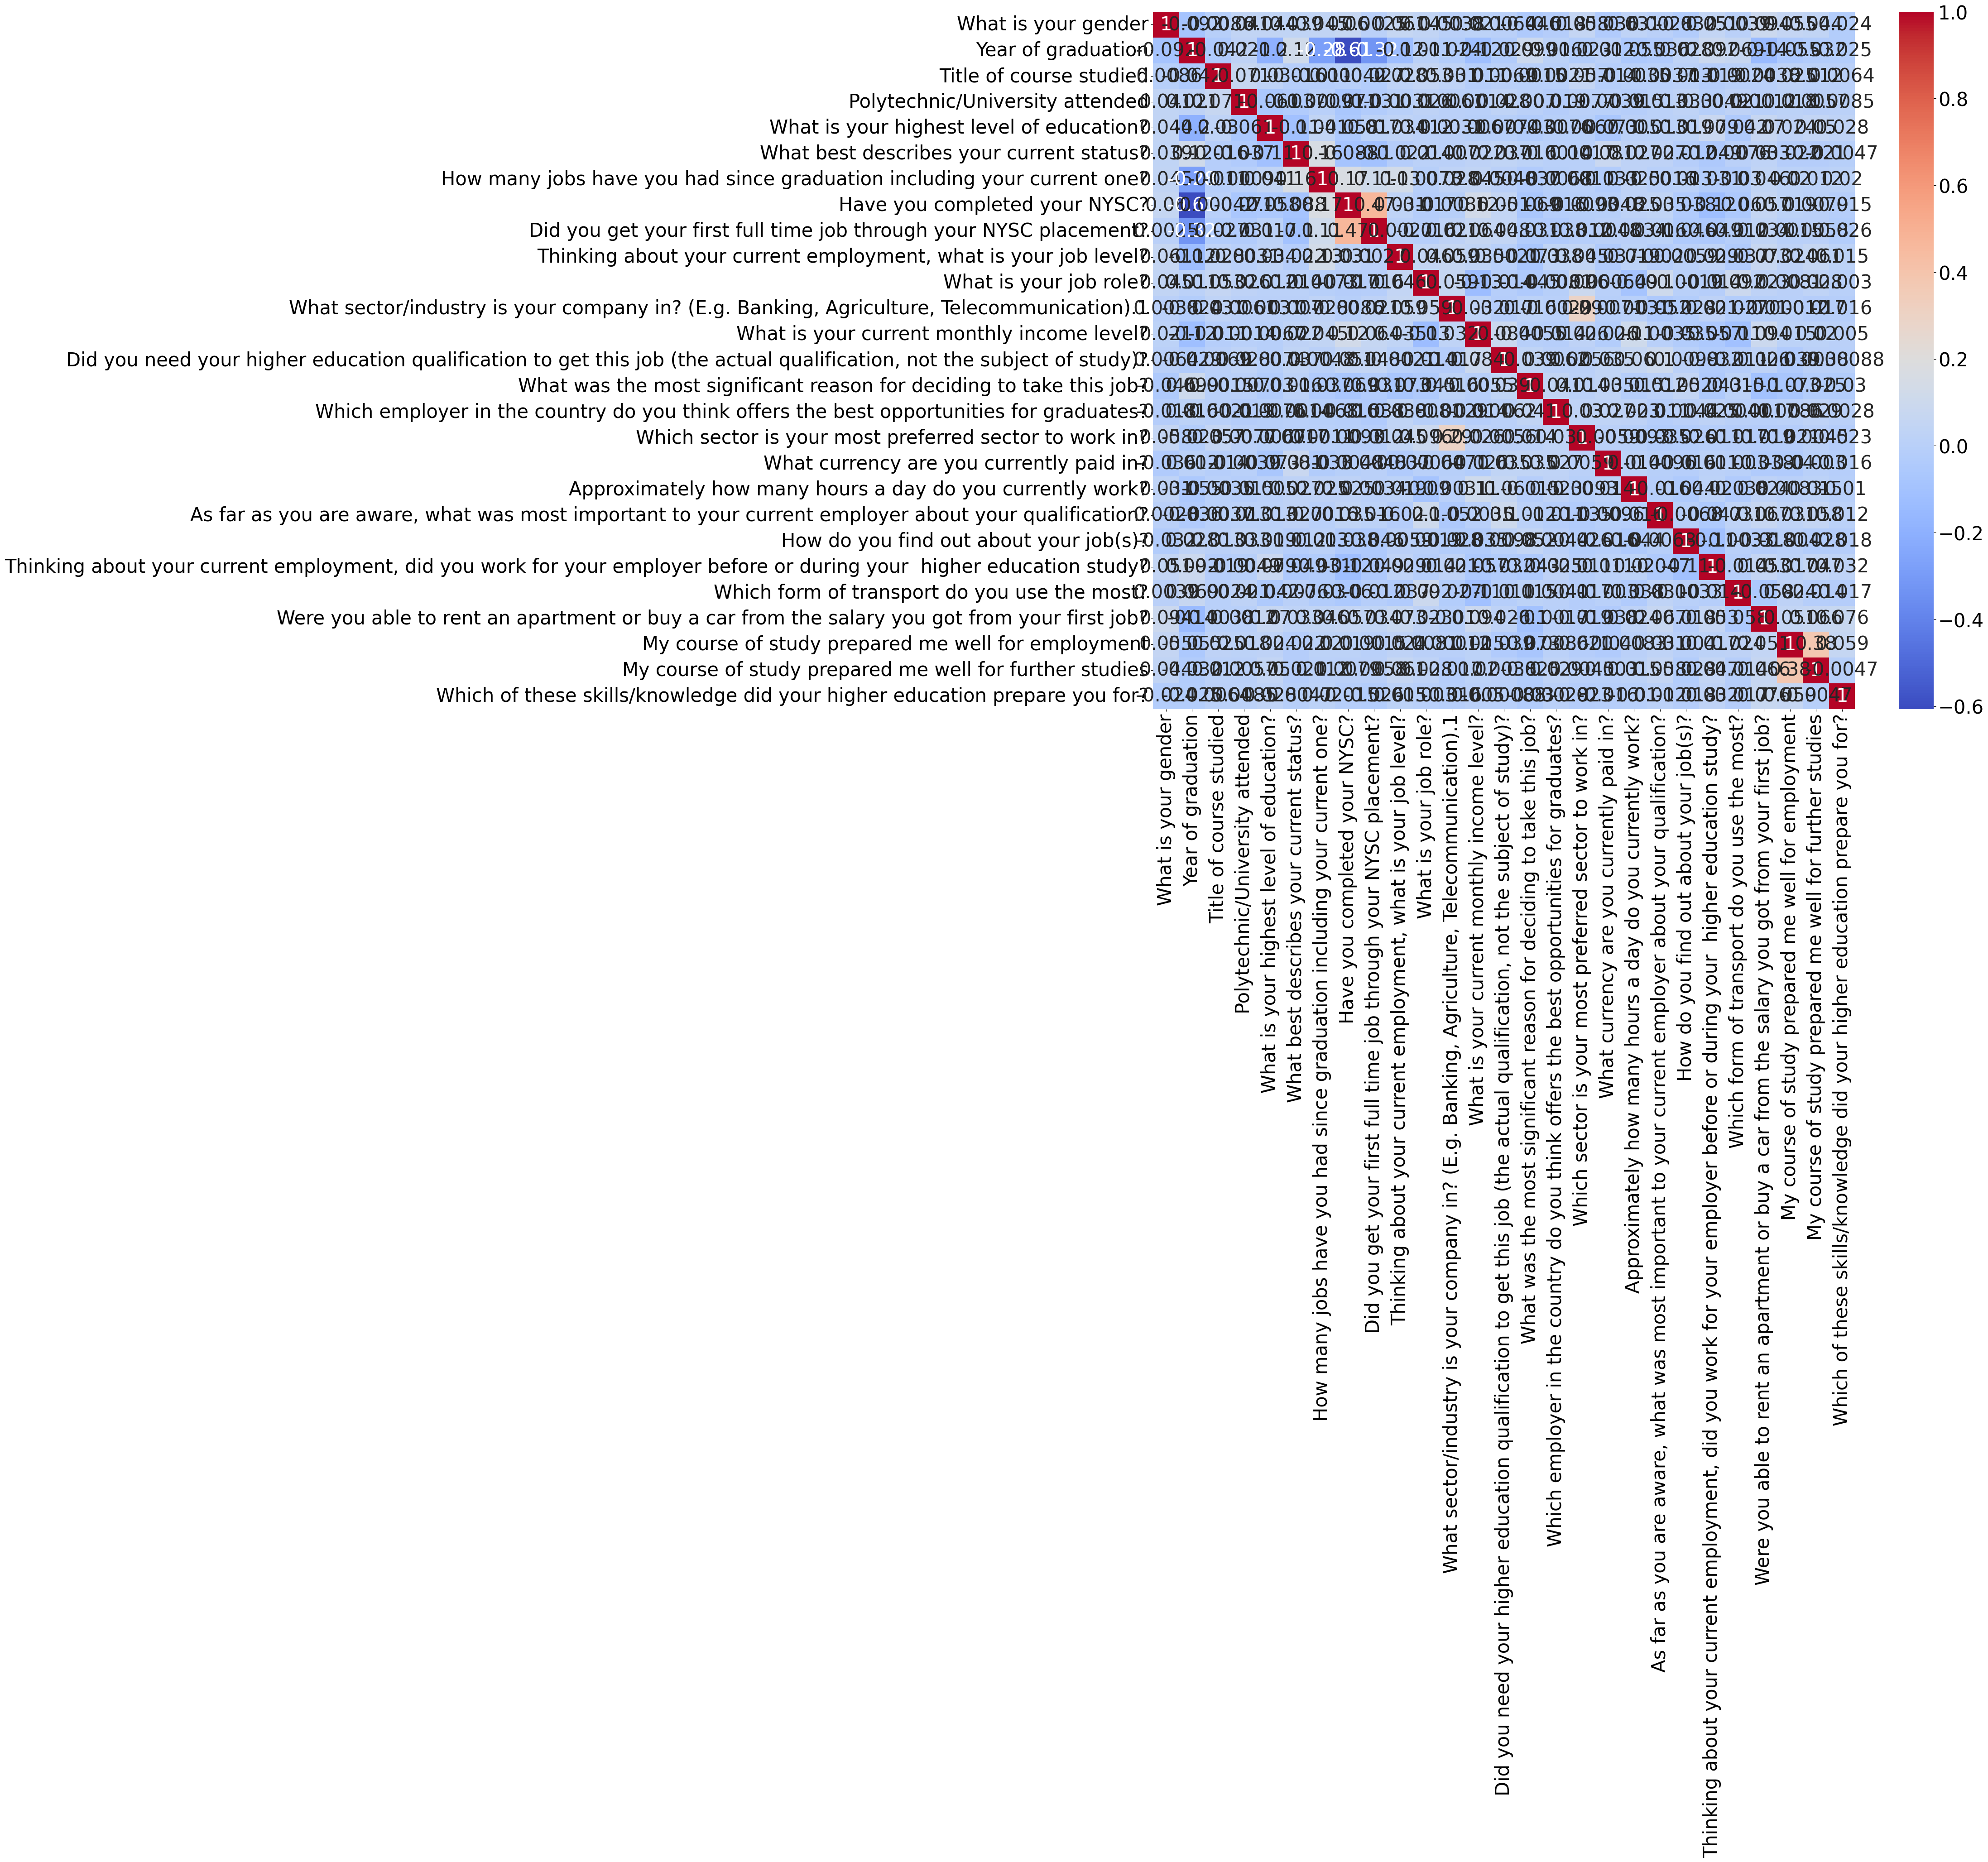

In [15]:
plt.figure(figsize=(25,20))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')


#### removing outliers

In [16]:
df.shape

(5219, 27)

In [25]:
df = df[(np.abs(stats.zscore(df.astype(float))) < 3).all(axis=1)]

In [26]:
df.shape

(4083, 27)

#### defining predictor variables and target variable

In [27]:
# Renaming "What best describes your current status?" to target

df.rename({"What best describes your current status?" : "target"}, axis = 1, inplace = True)

In [28]:
X = df.drop("target", axis = 1)
y = df["target"]

#### scaling the data

In [29]:
scaler = StandardScaler()

In [30]:
#scaling predictor variable
X = scaler.fit_transform(X.values)
X = pd.DataFrame(X)

#### splitting data into train and test set

In [31]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=42,shuffle=True)

## 5. Training

### LGBM Model

In [40]:
predictions = []
scores = []
i = 0
          
params = {'learning_rate': 0.1, 
          'subsample': 0.2128564969905326, 
          'colsample_bytree': 0.5046224462041669, 
          'max_depth': 13, 
          'scale_pos_weight': 4, 
          'n_estimators': 995,
          'objective': 'multiclass',
          'num_class': 10,
          'metric': 'multi_logloss',
          }

y = y.astype(float)
fold = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)

for train_index,test_index in fold.split(X,y):
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]
    classifier = LGBMClassifier(**params)
    classifier.fit(X_train,y_train)
    preds = classifier.predict(X_test)
    score = f1_score(y_test,preds, average="micro")
    scores.append(score)
    print("F1: " ,score)
    predictions.append(classifier.predict(X_test))
    i = i+1
    
print(np.mean(scores))




F1:  0.530562347188264
F1:  0.5354523227383863
F1:  0.5574572127139364
F1:  0.5196078431372549
F1:  0.5367647058823529
F1:  0.5416666666666666
F1:  0.5661764705882353
F1:  0.5612745098039216
F1:  0.5367647058823529
F1:  0.5392156862745098
0.5424942470875881


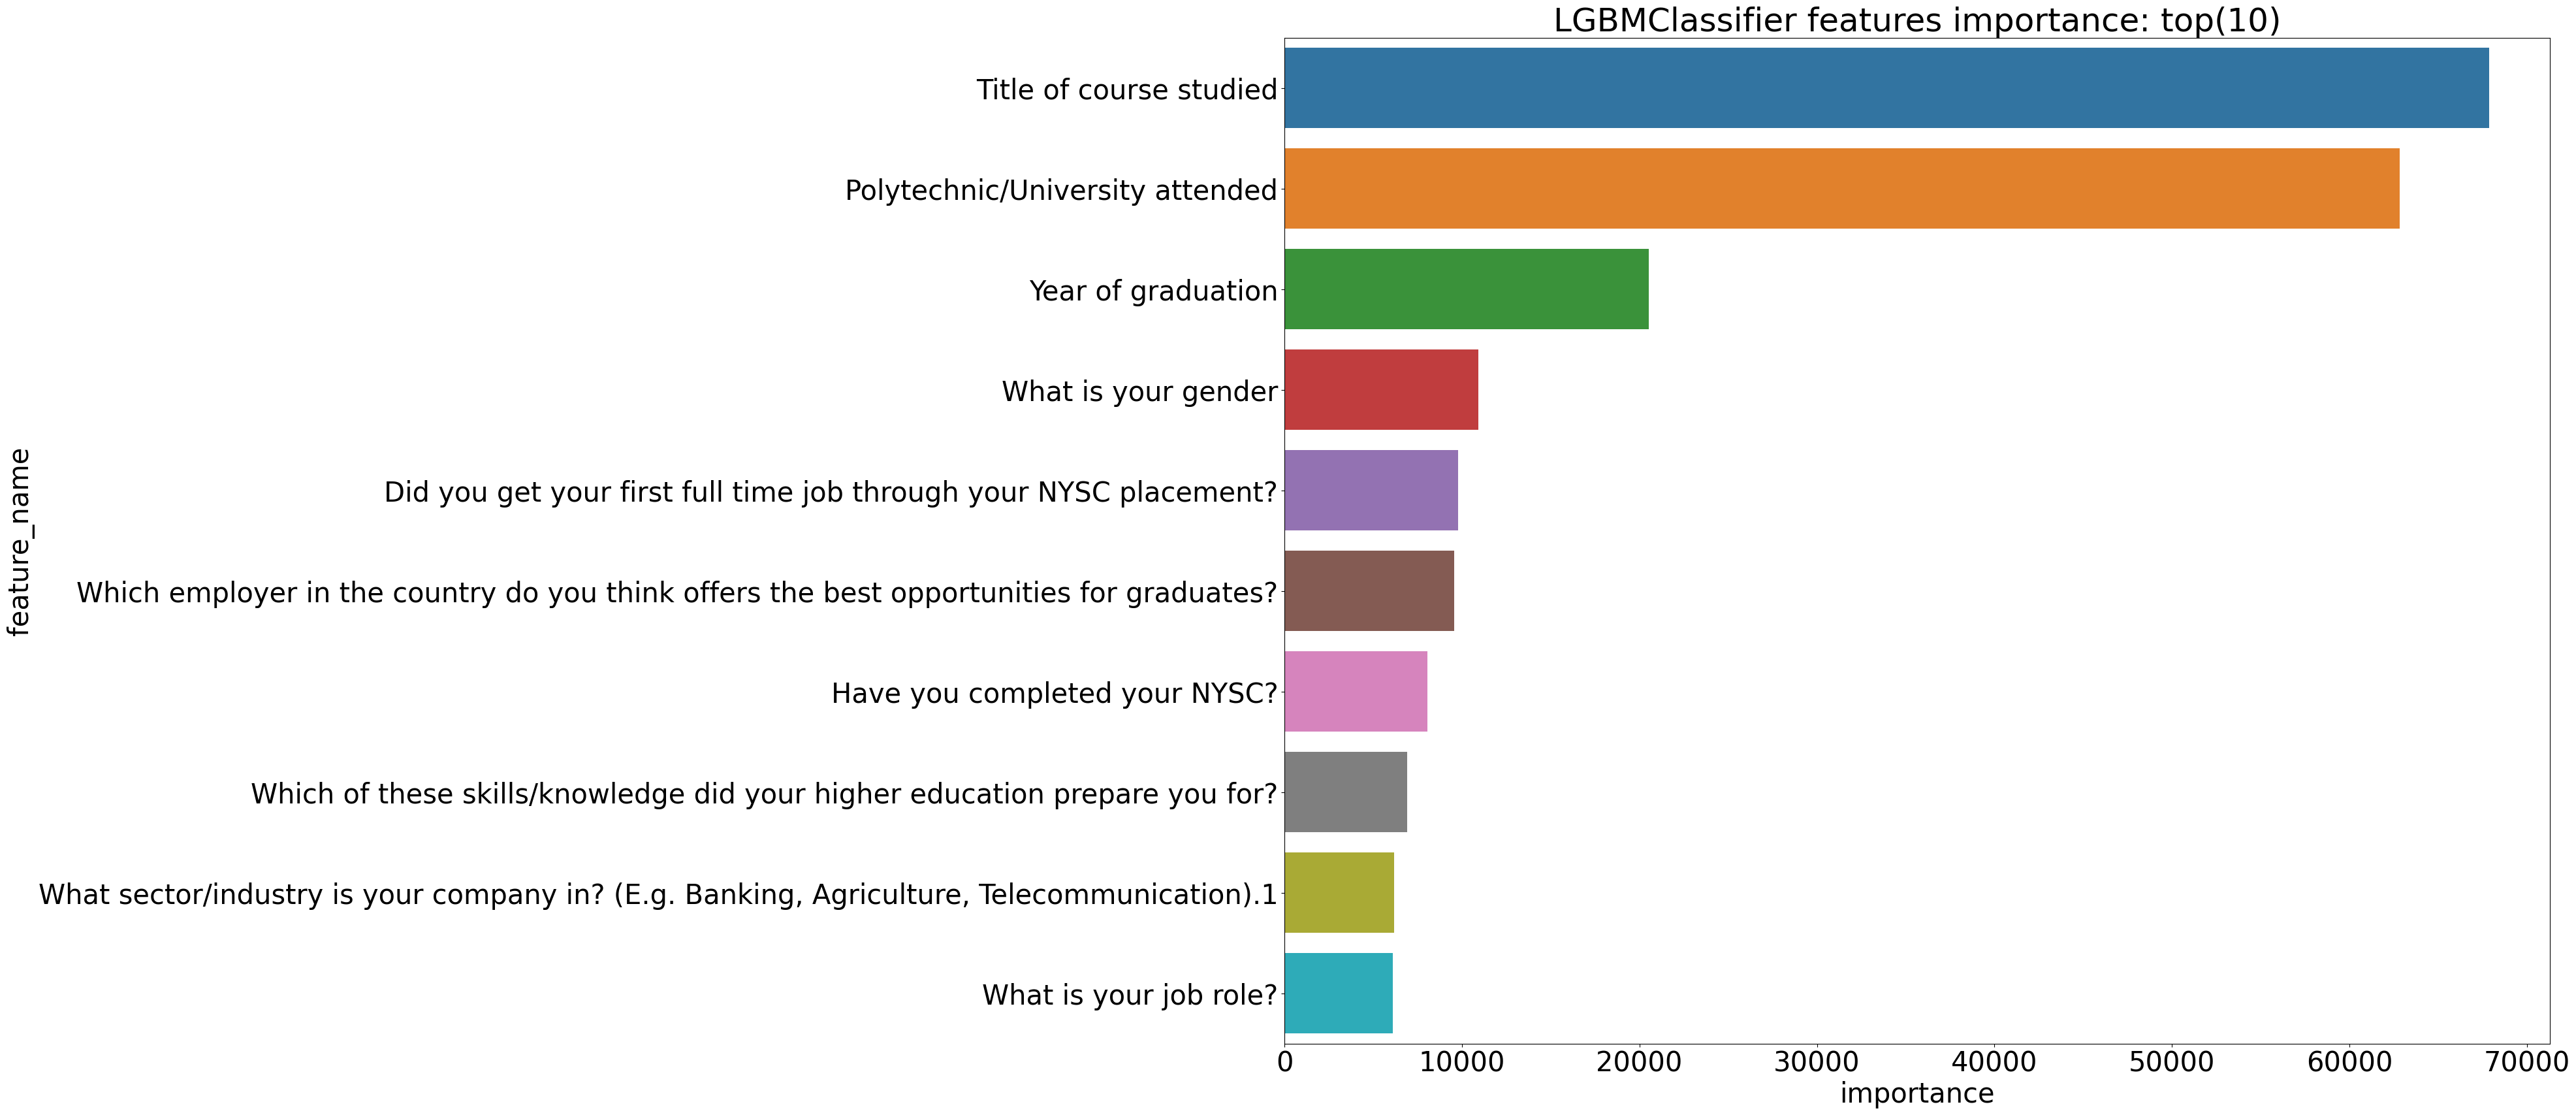

In [41]:
feature_importance_df = pd.DataFrame(classifier.feature_importances_, columns=['importance'])
feature_importance_df["feature_name"] = pd.Series(list(df.drop("target", axis = 1).columns))
feat_important = feature_importance_df.sort_values(by = ['importance'], ascending = False).head(10)

plt.figure(figsize=(25, 20));
plt.tight_layout()
sns.barplot(x="importance", y="feature_name",data = feat_important)
plt.title('LGBMClassifier features importance: top(10)');

In [ ]:
# The f1_score is 0.5424942470875881, 54%, its not good. Tryinging a different approach might have better results